In [ ]:
"""
Zachary Katz
zachary_katz@mines.edu
07 November 2025

Download one cycle of HR SWOT data over Amery Ice Shelf and plot elevation.
Can plot without context, but if background, grounding line, and velocity field are desired, they can be obtained from the links below.

RINGS 2022 Anatarctic grounding line
https://www.dropbox.com/scl/fi/386n1xlaz0jpcl46iwret/RINGS_products_2022.zip?rlkey=3izp1ptjcq4l62r3l8tswujcj&e=1&dl=0

MEaSUREs Velocity Map, v1
https://nsidc.org/data/nsidc-0754/versions/1

MOA 2009, v2
https://nsidc.org/data/nsidc-0593/versions/2

"""

# Imports and Extensions

import numpy as np

import xarray as xr
import shapefile
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import cartopy.crs as ccrs

from pathlib import Path
import earthaccess
from cmap import Colormap
import rasterio
import os

#############################
## User-Defined Parameters ##
cycle = '038' # SWOT Cycle to plot, must be 3 digits

use_background = False # If true, will plot background map, grounding line, and velocity field. Requires the paths below to be set.
gl_path = '/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/RINGS_2022/' # Path to Grounding Line
vel_mag_path = '/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/antarctic_ice_vel_phase_map_v01-vmag.nc' # Path to velocity field
moa_path = '/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/moa750_2009_hp1_v1.1.tif' # Path to MOA
## User-Defined Parameters ##
#############################


In [8]:
# Load backgrounds if using

if use_background:
    # RINGS 2022 Grounding Line
    rings_grounded_path = gl_path + 'RINGS_grounded_2022.shp'
    rings_coastline_path = gl_path + 'RINGS_coastline_2022.shp'
    rings_iceshelves_path = gl_path + 'RINGS_iceshelves_2022.shp'
    rings_islands_ADD = gl_path + 'RINGS_islands_ADD.shp'
    rings_polygonmask = gl_path + 'RINGS_polygonmask.shp'   


    paths = [
        rings_coastline_path,
        rings_grounded_path,
        rings_iceshelves_path,
        rings_islands_ADD,
        rings_polygonmask,
    ]

    records_full = []
    shapes_full = []
    field_names_full = []

    # Load grounding line components as shapefiles
    for path in paths:
        sf = shapefile.Reader(path)
        records_full.append(sf.records())
        shapes_full.append(sf.shapes())
        field_names_full.append([f[0] for f in sf.fields[1:]])

    def plot_RINGS_shapefile(
        records_list: list[shapefile._Record],
        shapes_list: list[shapefile.Shape],
        field_names_list: list[str],
        ax ,
        colors: list[str],
        transform,
        fill: bool = False,
        zorder: int = 2,
        linewidth: int = 2,
    ) -> None:
        """
        Plots the given records and shapes on axis ax.

        Parameters
        ----------
        records : list[shapefile._Record]
            Shapely record containing shape classification
        shapes : list[shapefile.Shape]
            Shapely shape points
        ax : cartopy.mpl.geoaxes.GeoAxes
            Axes to polot on
        colors : list[str]
        [Grounded ice color, Ice Shelf color]; Must be length 2
        """
        for records, shapes, field_names in zip(records_list, shapes_list, field_names_list):
            for record, shape in zip(records, shapes):
                rec_dict = dict(zip(field_names, record))
                classification = rec_dict["Type"]
                points = shape.points
                parts = list(shape.parts)
                parts.append(len(points)) # Append the end index of the last part of the shapefile
                for i in range(len(parts) - 1):
                        part = points[parts[i] : parts[i + 1]]
                        if classification == "Coastline":
                            if fill:
                                ax.fill(*zip(*part), color=colors[1], zorder=zorder,transform=transform)
                            else:
                                ax.plot(*zip(*part), color=colors[1], linewidth=linewidth, zorder=zorder,transform=transform)
                        elif classification == "Grounded":
                            if fill:
                                ax.fill(*zip(*part), color=colors[0], zorder=zorder,transform=transform)
                            else:
                                ax.plot(*zip(*part), color=colors[0], linewidth=linewidth, zorder=zorder,transform=transform)
                        elif classification == "Transient":
                            if fill:
                                ax.fill(*zip(*part), color=colors[0], zorder=zorder,transform=transform)
                            else:
                                ax.plot(*zip(*part), color=colors[0], linewidth=linewidth, zorder=zorder,transform=transform)
                        elif classification == "Island":
                            if fill:
                                ax.fill(*zip(*part), color=colors[0], zorder=zorder,transform=transform)
                            else:
                                ax.plot(*zip(*part), color=colors[0], linewidth=linewidth, zorder=zorder,transform=transform)
                        else:
                            pass

    # Load MOA
    with rasterio.open(moa_path) as moa:
        bounds = moa.bounds
        left, bottom, right, top = bounds.left, bounds.bottom, bounds.right, bounds.top
        moa_dat = moa.read(1)

    ext = (left, right, bottom, top)

    # Load and crop velocity magnitude
    oslo = Colormap('crameri:oslo').to_matplotlib()
    
    vel_mag = xr.open_dataarray(vel_mag_path)
    vel_mag_sliced = vel_mag.sel(x=slice(1500000,2500000),y=slice(850000,390000))

In [9]:
# Download SWOT data 
SWOT_PATH = f"./_Data/SWOT_Cycle{cycle}"
swot_bbox = (64.125,-75.0568,76.18359,-67.42255,)
karin_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_Raster_D', 
                                        temporal = ("2024-02-12", "2026-04-15"), 
                                        granule_name = f'*100m*x_{cycle}_*.nc',
                                        bounding_box = swot_bbox,) 

print(len(karin_results))
earthaccess.download(karin_results, SWOT_PATH, provider='POCLOUD')
rasters = list(Path(SWOT_PATH).glob('SWOT_L2_HR_Raster*.nc'))

34


QUEUEING TASKS | : 100%|██████████| 34/34 [00:00<00:00, 1819.75it/s]
PROCESSING TASKS | : 100%|██████████| 34/34 [00:00<00:00, 89296.39it/s]
COLLECTING RESULTS | : 100%|██████████| 34/34 [00:00<00:00, 156882.66it/s]


PLOTTING BACKGROUND
PLOTTING RASTERS
COLORBARS
SCALEBAR AND INSET


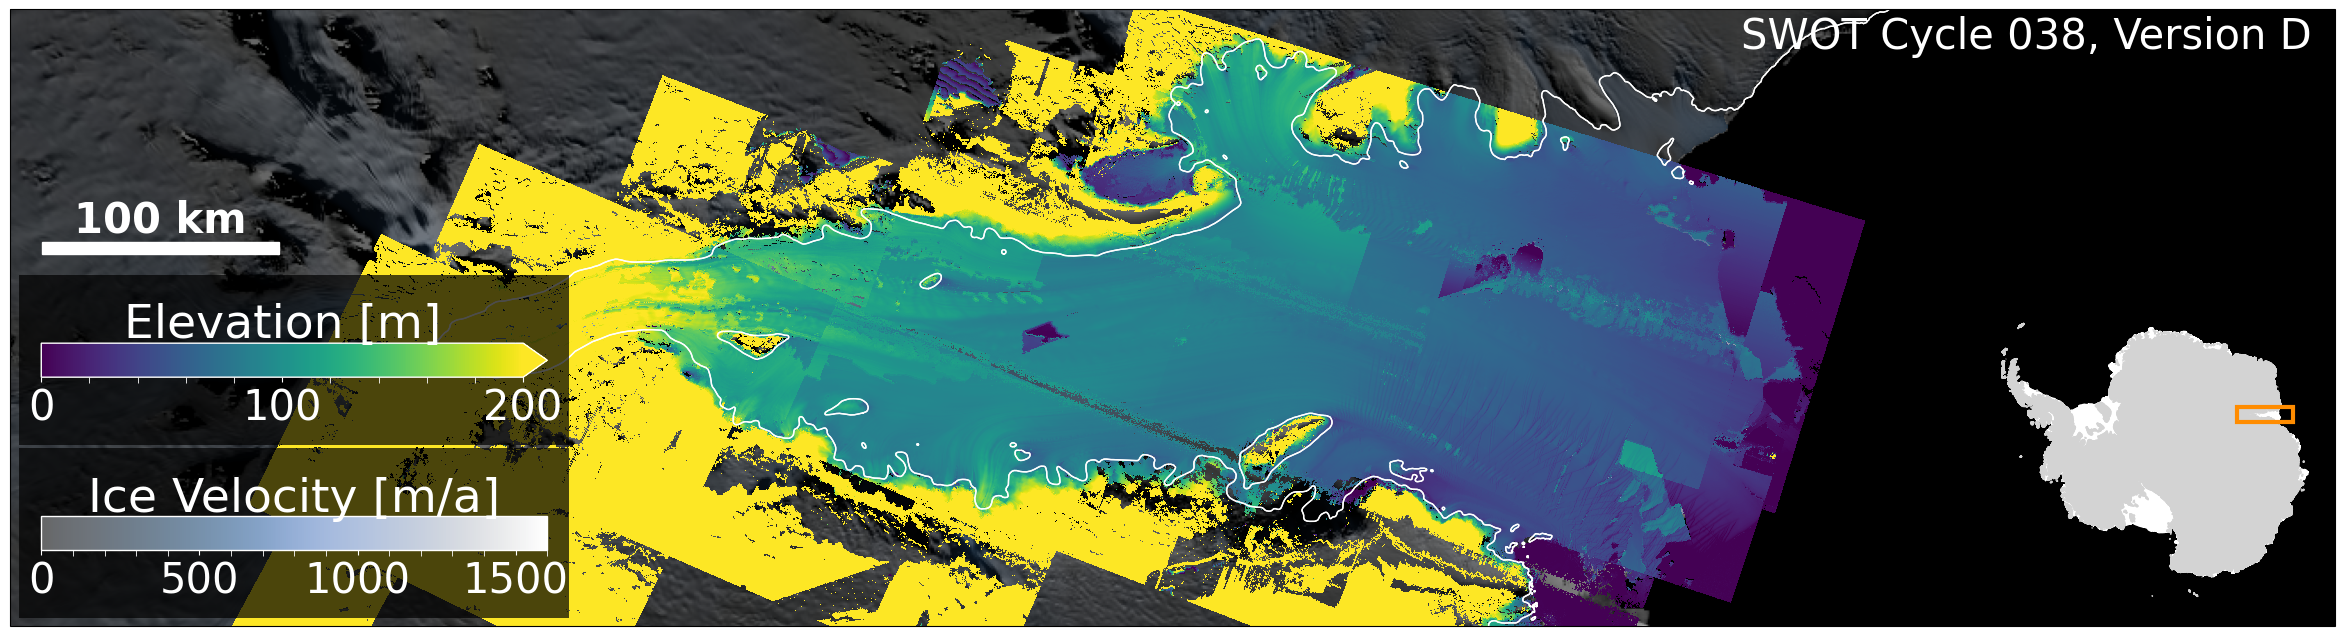

In [ ]:
# Plot multiple rasters
to_plot = 'wse' # Variable to plot
label = "Elevation [m]" # Plot label
vmin = 0 # Extent of to_plot
vmax = 200
bbox = [1500000,590000,2480000,850000] #Amery bounding box


# Setup plot
ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
fig, ax = plt.subplots(
    subplot_kw={'projection': ps71_projection},
    figsize=(30, 15)
)

if use_background:
    print("PLOTTING BACKGROUND")
    ax.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=17000)
    cb = ax.imshow(vel_mag_sliced, cmap=oslo,extent=[vel_mag_sliced['x'].min(), vel_mag_sliced['x'].max(),
        vel_mag_sliced['y'].min(), vel_mag_sliced['y'].max()],origin='upper',alpha=0.6,vmin=0,vmax=1600)
    plot_RINGS_shapefile(records_list=records_full, shapes_list=shapes_full, field_names_list=field_names_full, ax=ax, colors=['white','None'], transform=ps71_projection, fill=False, zorder=2, linewidth=1)
    

# Plot rasters
print("PLOTTING RASTERS")
for file in rasters[:]:  
    ds = xr.open_mfdataset(file,combine='nested',concat_dim="num_lines", decode_times=False)
    wse = ds[to_plot].isel(num_lines=0)
    if to_plot == 'wse':
        xover_corr = ds['height_cor_xover'].isel(num_lines=0)
        wse = wse + xover_corr
    utm = ccrs.UTM(zone=ds.utm_zone_num, southern_hemisphere=True)
    x = wse['x'].values
    y = wse['y'].values


    X, Y = np.meshgrid(x, y)
    mesh = ax.pcolormesh(
    X, Y, wse.values,
    transform=utm,
    cmap='viridis',
    shading='auto',
    vmin=vmin,
    vmax=vmax
    )


ax.set_xlim(bbox[0],bbox[2])
ax.set_ylim(bbox[1],bbox[3])

# Plot colorbar and scalebar
print("COLORBARS")
k_cbar_anchor = (0.001, 0.58)
cbbox = inset_axes(ax, width=5.5,height=1.7,
                bbox_to_anchor=k_cbar_anchor,
                bbox_transform=ax.transAxes, loc="upper left")
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(
    axis = 'both',
    left = False,
    top = False,
    right = False,
    bottom = False,
    labelleft = False,
    labeltop = False,
    labelright = False,
    labelbottom = False
)
cbbox.set_facecolor([0,0,0,0.7])

cbaxes = inset_axes(cbbox, '92%', '20%', loc = 'center')
cbar=fig.colorbar(mesh,cax=cbaxes, orientation='horizontal',extend='max') #make colorbar
cbar.outline.set_edgecolor('white')
cbar.outline.set_linewidth(1)
cbar.ax.tick_params(labelsize=30, color='white', labelcolor='white')
cbar.set_label(label, fontsize=34, color='white')
cbar.ax.xaxis.set_label_position('top')

cbar.ax.minorticks_on()

cbar.ax.tick_params(which='minor', length=4, color='white')


if use_background:
    v_cbar_anchor = (0.001, 0.001)
    cbbox = inset_axes(ax, width=5.5,height=1.7,
                    bbox_to_anchor=v_cbar_anchor,
                    bbox_transform=ax.transAxes, loc="lower left")
    [cbbox.spines[k].set_visible(False) for k in cbbox.spines]
    cbbox.tick_params(
        axis = 'both',
        left = False,
        top = False,
        right = False,
        bottom = False,
        labelleft = False,
        labeltop = False,
        labelright = False,
        labelbottom = False
    )
    cbbox.set_facecolor([0,0,0,0.7])

    cbaxes = inset_axes(cbbox, '92%', '20%', loc = 'center')
    cbar=fig.colorbar(cb,cax=cbaxes, orientation='horizontal') #make colorbar
    cbar.outline.set_edgecolor('white')
    cbar.outline.set_linewidth(1)
    cbar.ax.tick_params(labelsize=30, color='white', labelcolor='white')
    cbar.set_label('Ice Velocity [m/a]', fontsize=34, color='white')
    cbar.ax.xaxis.set_label_position('top')

    cbar.ax.minorticks_on()

    cbar.ax.tick_params(which='minor', length=4, color='white')

    print("SCALEBAR AND INSET")
    scalebar = AnchoredSizeBar(ax.transData,
                            100000, '100 km', 'lower left', 
                            pad=0.1,
                            sep=1,
                            color='white',
                            frameon=False,
                            size_vertical=5000,
                            fontproperties=mpl.font_manager.FontProperties(size=30, weight='bold'),
                            label_top=True)

    # Add inset map
    inset = fig.add_axes([0.74, 0.3, 0.2, 0.2], projection=ps71_projection)  # [left, bottom, width, height]
    inset.patch.set_facecolor('none')
    for spine in inset.spines.values():
        spine.set_visible(False)
    inset.set_xticks([])
    inset.set_yticks([])

    plot_RINGS_shapefile(records_list=records_full, shapes_list=shapes_full, field_names_list=field_names_full, ax=inset, colors=['lightgray','white'],
                        transform=ps71_projection, fill=True, zorder=2, linewidth=1)


    rect = plt.Rectangle(
        (bbox[0],bbox[1],),bbox[2]-bbox[0], bbox[3]-bbox[1], zorder=3,linewidth=3,edgecolor='darkorange',facecolor='none')
    inset.add_patch(rect)


    ax.add_artist(scalebar)
    scalebar.set_bbox_to_anchor((0.01, 0.59), transform=ax.transAxes)


ax.text(
    0.99,
    0.99,
    f"SWOT Cycle {cycle}, Version D",
    ha="right",
    va="top",
    fontsize=30,
    color='white',
    transform=ax.transAxes,
)

os.makedirs('./Output', exist_ok=True)
if use_background:
    fig.savefig(f'./Output/SWOT_Cycle{cycle}_withBackground.png', dpi=300, bbox_inches='tight')
else:
    fig.savefig(f'./Output/SWOT_Cycle{cycle}_noBackground.png', dpi=300, bbox_inches='tight')
